# BCM for aggreagated months with heterogeneous noise

7th March 2024


In [1]:
# Import libraries
import glob
import gpflow

import scipy as sp
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from gpflow.conditionals.util import sample_mvn

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import tqdm

In [3]:
# Custom libraries
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/')
import guepard
from models import bcm
from utils.areal_plots import seasonal_means

In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

## Load and prepare data

In [6]:
rcm_list = []
lambdas = []
scalers = []
p95_list = []


for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical*2006.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df[(df['lon'] > 60) & (df['lat'] > 30) & (df['lon'] < 70) & (df['lat'] < 35)]
    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    p95 = np.percentile(loc_df['tp'], 95)

    y_scaler = StandardScaler()
    loc_df['tp_bc'], lmbda = sp.stats.boxcox(loc_df['tp']+0.001)
    tp_tr = y_scaler.fit_transform(loc_df['tp_bc'].values.reshape(-1, 1))
    loc_df['tp_tr'] = tp_tr

    scalers.append(y_scaler)
    p95_list.append(p95)
    lambdas.append(lmbda)
    rcm_list.append(loc_df[['month', 'lon', 'lat', 'tp_tr']])


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['time'] = pd.to_datetime(loc_df['time'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/1752450007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_df['month'] = loc_df['time'].dt.month


In [7]:
rcm_df = rcm_list[1]

In [8]:
rcm_df

,month,lon,lat,tp_tr
20,1,60.25,30.25,0.781021
43220,1,60.25,30.25,0.864232
86420,1,60.25,30.25,-0.873850
129620,1,60.25,30.25,-0.079758
172820,1,60.25,30.25,-0.293354
...,...,...,...,...
1120389,12,69.75,34.75,-0.435015
1163589,12,69.75,34.75,-0.075647
1206789,12,69.75,34.75,0.802416
1249989,12,69.75,34.75,0.852062


<Axes: >

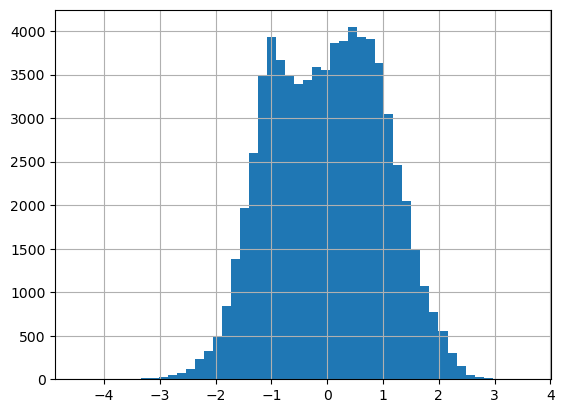

In [9]:
rcm_df['tp_tr'].hist(bins=50)

## Fit warped GP to aggregated data

In [10]:
class FixedVarianceOfMean(gpflow.functions.Function):
    def __init__(self, Y: gpflow.base.AnyNDArray):
        self.var_mean = np.var(Y, axis=-2).reshape(-1, 1)

    def __call__(self, X: gpflow.base.TensorType) -> tf.Tensor:
        return self.var_mean

In [11]:
rcm_df_loc = rcm_df[(rcm_df['lon'] == 60.75) & (rcm_df['lat'] == 30.75)]

In [12]:
rcm_df_loc

,month,lon,lat,tp_tr
61,1,60.75,30.75,0.851268
43261,1,60.75,30.75,0.835995
86461,1,60.75,30.75,-0.853512
129661,1,60.75,30.75,0.038053
172861,1,60.75,30.75,-0.069865
...,...,...,...,...
1119661,12,60.75,30.75,-0.864643
1162861,12,60.75,30.75,0.087103
1206061,12,60.75,30.75,-0.251378
1249261,12,60.75,30.75,0.623004


In [13]:
mean_df= rcm_df_loc[['month', 'tp_tr']].groupby(by='month').mean().reset_index()

In [14]:
mean_df

,month,tp_tr
0,1,-0.345661
1,2,-0.020558
2,3,0.281748
3,4,0.239792
4,5,-0.291318
5,6,-0.834288
6,7,-0.518659
7,8,-0.290499
8,9,-0.771281
9,10,-0.578182


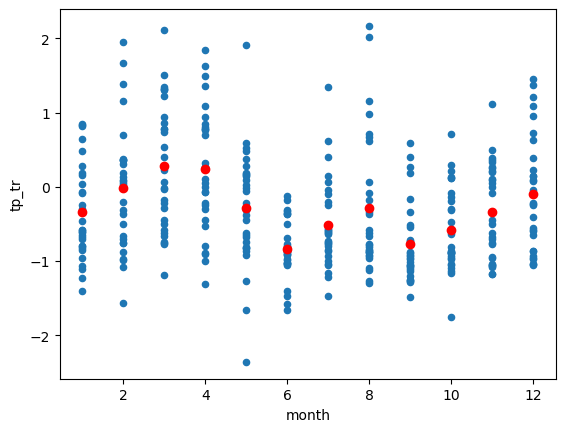

In [15]:
rcm_df_loc.plot.scatter(x='month', y='tp_tr')
plt.scatter(mean_df['month'], mean_df['tp_tr'], c='r')

### Modelling the mean of the RCM climatology independently

In [16]:
# Gaussian Process regression model with GPflow
# Define the kernel

X = rcm_df_loc['month'].astype(np.float64).values.reshape(-1, 1)#.drop_duplicates().values
Y = rcm_df_loc['tp_tr'].values.reshape(-1, 1)

X_mean =  mean_df['month'].values.reshape(-1, 1).astype(np.float64)
Y_mean = mean_df['tp_tr'].values.reshape(-1, 1).astype(np.float64)

k = gpflow.kernels.Matern52(lengthscales=1, variance=3)
mean_m = gpflow.models.GPR(data=(X_mean, Y_mean), kernel=k, noise_variance=0.01)
                        #likelihood=gpflow.likelihoods.Gaussian(variance=FixedVarianceOfMean(Y)),
                      

In [17]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(mean_m.training_loss, mean_m.trainable_variables, options=dict(maxiter=200))
gpflow.utilities.print_summary(mean_m)

2024-03-21 14:56:33.743099: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.19801 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.50552 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

2024-03-21 14:56:34.660942: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [18]:
x_plt = np.linspace(1, 12, 100)
y_preds = mean_m.predict_f(x_plt.reshape(-1, 1))
u = y_preds[0].numpy().flatten()
v = y_preds[1].numpy().flatten()

In [19]:
samples = mean_m.predict_f_samples(x_plt.reshape(-1, 1), 3)

In [20]:
Y_var

NameError: name 'Y_var' is not defined

NameError: name 'Y_var' is not defined

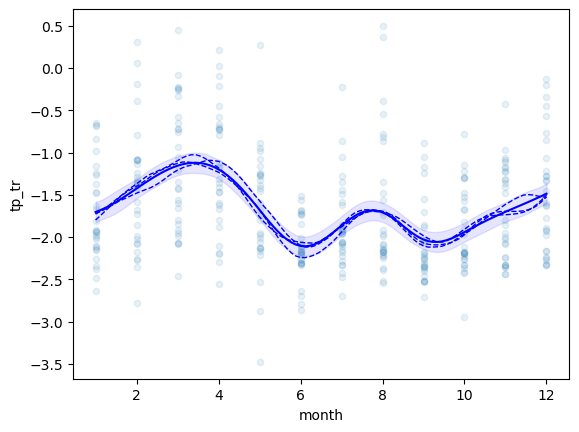

In [ ]:
rcm_df_loc.plot.scatter(x='month', y='tp_tr', alpha=0.1)
plt.plot(x_plt, u, color='blue')
for i in range(3):
    plt.plot(x_plt, samples[i, :], color='blue', lw=1, ls='--')
plt.fill_between(x_plt, u - 1.96 * np.sqrt(v), u + 1.96 * np.sqrt(v), alpha=0.1, color='blue')
plt.fill_between(X_mean.reshape(-1), (Y_mean - 1.96 * np.sqrt(Y_var)).reshape(-1), (Y_mean + 1.96 * np.sqrt(Y_var)).reshape(-1), alpha=0.1, color='orange')
plt.scatter(np.arange(1,13), Y_mean, color='green')

KeyError: 'tp_scale'

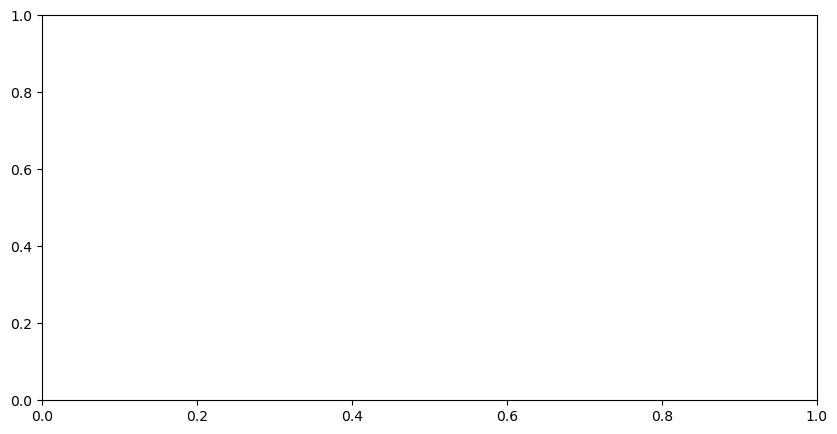

In [21]:
i = 1 # RCM index 
fig, ax = plt.subplots(1,1,figsize=(10, 5))
rcm_df_loc.plot.scatter(x='month', y='tp_scale', ax=ax)
plt.plot(x_plt, inv_boxcox(u, lambdas[1]), color='red')
plt.fill_between(x_plt, inv_boxcox(u - 1.96 * np.sqrt(v), lambdas[i]), inv_boxcox(u + 1.96 * np.sqrt(v), lambdas[i]), alpha=0.2, color='red')
plt.scatter(np.arange(1,13), inv_boxcox(Y_mean, lambdas[1]), color='green')

### Modelling the variance of the RCM climatology independently

In [22]:
import tensorflow_probability as tfp

In [23]:
var_df= rcm_df_loc[['month', 'tp_tr']].groupby(by='month').var().reset_index()

In [24]:
var_df['month'].values.reshape(-1, 1).astype(np.float64)

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.]])

In [25]:
# Gaussian Process regression model with GPflow
# Define the kernel

X_var = var_df['month'].values.reshape(-1, 1).astype(np.float64)
Y_var = var_df['tp_tr'].values.reshape(-1, 1).astype(np.float64)

k2 = gpflow.kernels.Matern52(lengthscales=0.3, variance=4)
var_m = gpflow.models.GPR(data=(X_var, Y_var), kernel=k2, noise_variance=0.001)
                      #likelihood=gpflow.likelihoods.Gaussian(variance=FixedVarianceOfMean(Y)),
                      #mean_function=None)
var_m.kernel.lengthscales.prior = tfp.distributions.Normal(loc=np.float64(3), scale=np.float64(1))
var_m.likelihood.variance.prior = tfp.distributions.Normal(loc=np.float64(0.001), scale=np.float64(0.01))
gpflow.utilities.print_summary(var_m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   4     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │   0.3   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ Normal  │ True        │ ()      │ float64 │   0.001 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [26]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(var_m.training_loss, var_m.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(var_m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.30727 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │ Normal  │ True        │ ()      │ float64 │ 1.86047 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ Normal  │ True        │ ()      │ float64 │ 0.00698 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [27]:
x_plt = np.linspace(1, 12, 100)
y_preds = var_m.predict_f(x_plt.reshape(-1, 1))
var = y_preds[0].numpy().flatten()
v = y_preds[1].numpy().flatten()

In [28]:
Y_var
X_var


array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.]])

In [29]:
var

array([0.416257  , 0.44727302, 0.47877999, 0.51035347, 0.54151539,
       0.57175423, 0.60054684, 0.62738347, 0.65179831, 0.67340753,
       0.69195657, 0.70735174, 0.71963333, 0.72893394, 0.73544755,
       0.7394089 , 0.74108186, 0.74075594, 0.73875068, 0.73542706,
       0.73119161, 0.72646899, 0.7216652 , 0.71713376, 0.71314338,
       0.70984483, 0.70723515, 0.705117  , 0.70305223, 0.70034022,
       0.69607242, 0.68921448, 0.67868838, 0.66345865, 0.64262838,
       0.61555091, 0.58196414, 0.54215134, 0.49704246, 0.44810955,
       0.39720088, 0.34639813, 0.29789029, 0.25385572, 0.21634322,
       0.18714367, 0.16764579, 0.15873455, 0.16083477, 0.17399192,
       0.19792562, 0.23205601, 0.27550483, 0.3270718 , 0.38518619,
       0.44783498, 0.5125316 , 0.57643182, 0.63649971, 0.68966973,
       0.7330141 , 0.76392785, 0.78034447, 0.78099643, 0.76572922,
       0.7356951 , 0.69313018, 0.64100869, 0.58274538, 0.5219346 ,
       0.46210853, 0.40649783, 0.3577782 , 0.31779146, 0.28736

In [30]:
samples = var_m.predict_f_samples(x_plt.reshape(-1, 1), 3)

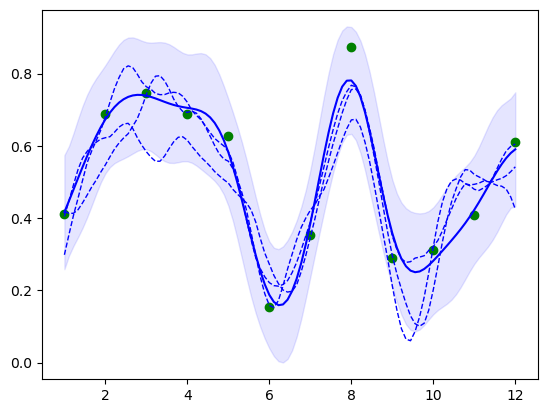

In [31]:
plt.plot(x_plt, var, color='blue')
plt.fill_between(x_plt, var - 1.96 * np.sqrt(v), var + 1.96 * np.sqrt(v), alpha=0.1, color='blue')
for i in range(3):
    plt.plot(x_plt, samples[i, :], color='blue', lw=1, ls='--')
plt.scatter(np.arange(1,13), Y_var, color='green')

### Model variance and mean together

In [32]:
likelihood = gpflow.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

In [33]:
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpflow.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)

# The number of kernels contained in gpf.kernels.SeparateIndependent must be the same as likelihood.latent_dim

In [34]:
M = 12  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpflow.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpflow.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

In [35]:
model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,)

In [36]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [37]:
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(12, 1)",float64,[[1....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(12, 1)",float64,[[1....
SVGP.q_mu,Parameter,Identity,,False,"(12, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 12, 12)",float64,"[[[1., 0., 0...."


In [38]:
epochs = 200
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")

Instructions for updating:
Use fn_output_signature instead
Epoch 20 - Loss:  418.2077
Epoch 40 - Loss:  409.0485
Epoch 60 - Loss:  407.1523
Epoch 80 - Loss:  406.1185
Epoch 100 - Loss:  405.4074
Epoch 120 - Loss:  404.8621
Epoch 140 - Loss:  404.4223
Epoch 160 - Loss:  404.0537
Epoch 180 - Loss:  403.7357
Epoch 200 - Loss:  403.4579


In [172]:
x_plt2 = np.linspace(0, 13, 200)

In [105]:
means, unc = model.predict_f(x_plt2[:, None])
model.likelihood.predict_mean_and_var(x_plt2[:, None], means, unc)

(<tf.Tensor: shape=(200, 1), dtype=float64, numpy=
 array([[-3.18206256e-01],
        [-2.97455589e-01],
        [-2.72904202e-01],
        [-2.44800605e-01],
        [-2.13458063e-01],
        [-1.79247090e-01],
        [-1.42587543e-01],
        [-1.03940931e-01],
        [-6.38035014e-02],
        [-2.27005588e-02],
        [ 1.88177267e-02],
        [ 6.01789513e-02],
        [ 1.00789715e-01],
        [ 1.40035867e-01],
        [ 1.77282356e-01],
        [ 2.11873470e-01],
        [ 2.43134349e-01],
        [ 2.70374663e-01],
        [ 2.92895341e-01],
        [ 3.09999023e-01],
        [ 3.21004730e-01],
        [ 3.25266897e-01],
        [ 3.22198551e-01],
        [ 3.11298036e-01],
        [ 2.92178230e-01],
        [ 2.64596875e-01],
        [ 2.28486277e-01],
        [ 1.83980410e-01],
        [ 1.31437352e-01],
        [ 7.14549935e-02],
        [ 4.87810533e-03],
        [-6.72048178e-02],
        [-1.43476082e-01],
        [-2.22415270e-01],
        [-3.02337585e-01],
    

In [107]:
means

<tf.Tensor: shape=(200, 2), dtype=float64, numpy=
array([[-3.18206256e-01, -4.06761412e-01],
       [-2.97455589e-01, -3.86109510e-01],
       [-2.72904202e-01, -3.62024897e-01],
       [-2.44800605e-01, -3.35407650e-01],
       [-2.13458063e-01, -3.07280219e-01],
       [-1.79247090e-01, -2.78736919e-01],
       [-1.42587543e-01, -2.50885224e-01],
       [-1.03940931e-01, -2.24782213e-01],
       [-6.38035014e-02, -2.01370285e-01],
       [-2.27005588e-02, -1.81416733e-01],
       [ 1.88177267e-02, -1.65461946e-01],
       [ 6.01789513e-02, -1.53780834e-01],
       [ 1.00789715e-01, -1.46361438e-01],
       [ 1.40035867e-01, -1.42903724e-01],
       [ 1.77282356e-01, -1.42840206e-01],
       [ 2.11873470e-01, -1.45378422e-01],
       [ 2.43134349e-01, -1.49563522e-01],
       [ 2.70374663e-01, -1.54357420e-01],
       [ 2.92895341e-01, -1.58729335e-01],
       [ 3.09999023e-01, -1.61751171e-01],
       [ 3.21004730e-01, -1.62690306e-01],
       [ 3.25266897e-01, -1.61091985e-01],
    

In [173]:
Ymean, Yvar = model.predict_y(x_plt2.reshape(-1, 1))
Ymean = Ymean.numpy().squeeze()
Ystd = tf.sqrt(Yvar).numpy().squeeze()

In [194]:
def plot_distribution(X, x_plt, Y, loc, scale):
    plt.figure(figsize=(6, 5))
    x = X.squeeze()
    for k in (1, 2):
        lb = (loc - k * scale).squeeze()
        ub = (loc + k * scale).squeeze()
        plt.fill_between(x_plt, lb, ub, color="lightskyblue", alpha=1 - 0.05 * k ** 3, label=f"${k}\sigma$")
    plt.plot(x_plt, lb, color="lightskyblue")
    plt.plot(x_plt, ub, color="lightskyblue")
    plt.plot(x_plt, loc, color="black", label='Posterior mean')
    plt.scatter(X, Y, alpha=0.8, label='RCM output', zorder=10)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Transformed precipitation", fontsize=12)
    plt.xlim(0, 13)
    plt.ylim(-3, 5)
    plt.legend()
    plt.savefig("chained_gp_timeseries.pdf")
    plt.show()
    plt.close()

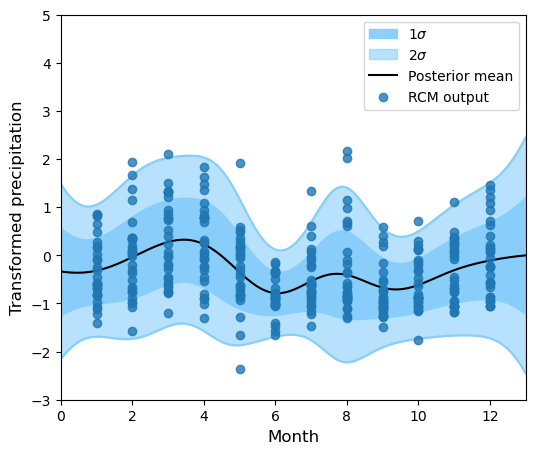

In [195]:
plot_distribution(X, x_plt2, Y, Ymean, Ystd)

### BCM model on timeseries

In [117]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
kernel1 = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpflow.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)

In [119]:
Xl = [X, X]
Yl = [Y, Y]
Ml = [12, 12]
submodels = bcm.get_latent_submodels(Xl, inducing_pts=Xl, kernel=kernel1, likelihood=likelihood)

100%|██████████| 2/2 [00:00<00:00, 92.98it/s]


In [154]:
m_bcm1 = guepard.baselines.latent_Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.BCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [150]:
gpflow.utilities.set_trainable(m_bcm1.models[0].inducing_variable.inducing_variable_list[0].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[0].inducing_variable.inducing_variable_list[1].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[1].inducing_variable.inducing_variable_list[0].Z, False)
gpflow.utilities.set_trainable(m_bcm1.models[1].inducing_variable.inducing_variable_list[1].Z, False)

In [151]:
m_bcm1.models[0]

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.97185
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.02864
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.98594
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.99821
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,False,"(360, 1)",float64,[[1....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,False,"(360, 1)",float64,[[1....
SVGP.q_mu,Parameter,Identity,,False,"(360, 2)",float64,"[[-3.3653e-01, -2.8165e-01..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 360, 360)",float64,"[[[1.6397e-01, 0.0000e+00, 0.0000e+00..."


In [152]:
loss_fn = m_bcm1.training_loss(Xl, Yl)

variational_vars = m_bcm1.variational_variables
#variational_vars = [[variational_vars[0][0], variational_vars[1][0]], [variational_vars[0][1], variational_vars[1][1]]]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

adam_vars = tuple(m_bcm1.trainable_variables)
adam_opt = tf.optimizers.Adam(0.001)

# @tf.function
def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

In [155]:
epochs = 200
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")

Epoch 20 - Loss:  820.6938
Epoch 40 - Loss:  819.7799
Epoch 60 - Loss:  818.9385
Epoch 80 - Loss:  818.1188
Epoch 100 - Loss:  817.3232
Epoch 120 - Loss:  816.5568
Epoch 140 - Loss:  815.8240
Epoch 160 - Loss:  815.1278
Epoch 180 - Loss:  814.4702
Epoch 200 - Loss:  813.8522


In [156]:
Ymean, Yvar = m_bcm1.predict_y(x_plt2.reshape(-1, 1))
Ymean = Ymean.numpy().squeeze()
Ystd = tf.sqrt(Yvar).numpy().squeeze()

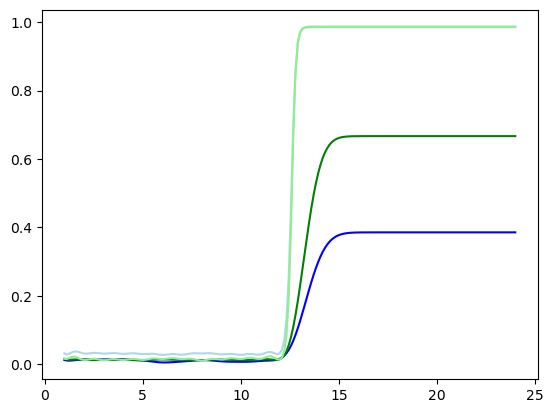

In [130]:
plt.plot(x_plt2, var_f[:, 0], color='blue')
plt.plot(x_plt2, var_f2[:, 0], color='lightblue')
plt.plot(x_plt2, var_f[:, 1], color='green')
plt.plot(x_plt2, var_f2[:, 1], color='lightgreen')

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_1833/3742259504.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(x_plt2, mean_f2[:,0] - 1.96 * np.sqrt(mean_f2[:,1]), mean_f2[:,0] + 1.96 * np.sqrt(mean_f2[:,1]), alpha=0.1)


(-4.0, 4.0)

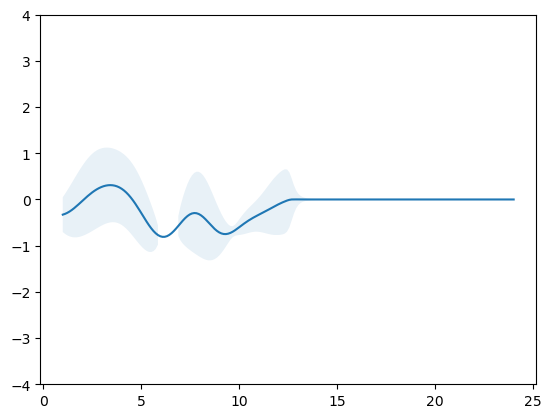

In [132]:
plt.plot(x_plt2, mean_f2[:,0])
plt.fill_between(x_plt2, mean_f2[:,0] - 1.96 * np.sqrt(mean_f2[:,1]), mean_f2[:,0] + 1.96 * np.sqrt(mean_f2[:,1]), alpha=0.1)
plt.ylim(-4,4)

(-4.0, 4.0)

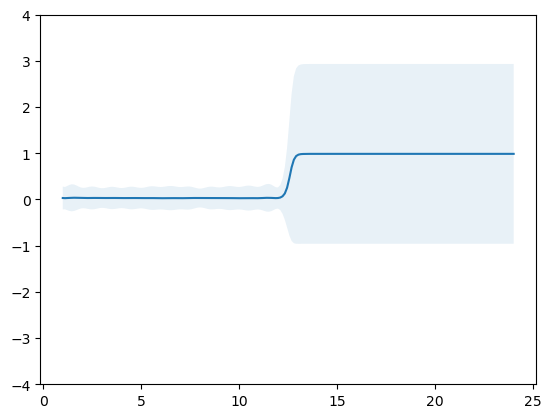

In [147]:
plt.plot(x_plt2, var_f2[:,0])
plt.fill_between(x_plt2, var_f2[:,0] - 1.96 * np.sqrt(var_f2[:,1]), var_f2[:,0] + 1.96 * np.sqrt(var_f2[:,1]), alpha=0.1)
plt.ylim(-4,4)

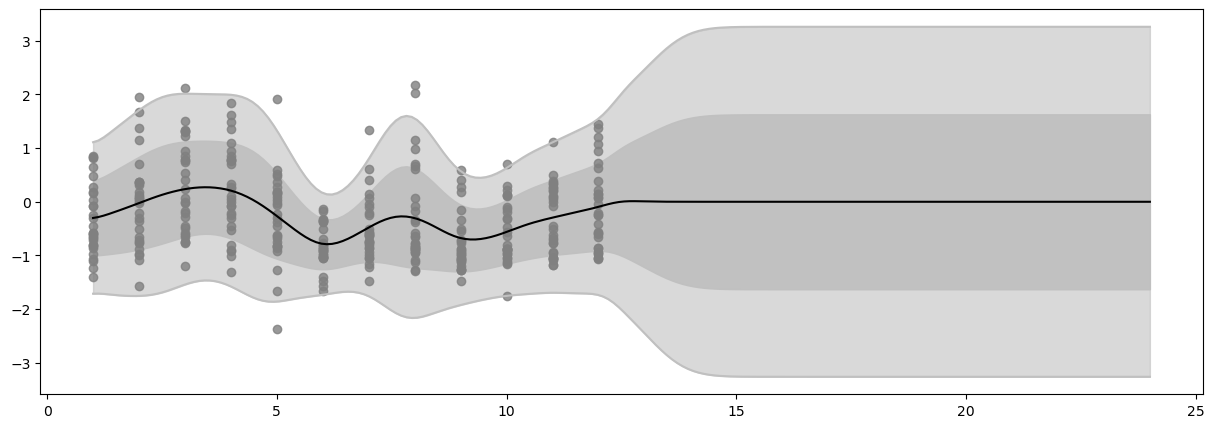

In [157]:
plot_distribution(X, x_plt2, Y, Ymean, Ystd)

## BCM model on subset of data

In [431]:
from models import bcm

In [414]:
# using groupby, crate catergories along lon and lat columns, for rcm_df
rcm_df['lat_group'] = pd.cut(rcm_df['lat'], 5, labels=np.arange(5))
rcm_df['lon_group'] = pd.cut(rcm_df['lon'], 5, labels=np.arange(5))

In [415]:
df_list = []
gb = rcm_df.groupby(['lon_group', 'lat_group',])
df_list.extend([gb.get_group(x)[['month', 'lon', 'lat', 'tp_tr',]].values for x in gb.groups])

In [416]:
arr = np.array(df_list)
arr.shape

(25, 2880, 4)

In [417]:
arr_ = np.stack([arr[[0,1,2,5,6,7,10,11,12]], arr[[2,3,4,7,8,9,12,13,14]], arr[[10,11,12,15,16,17,20,21,22]], arr[[12,13,14,17,18,19,22,23,24]]])

In [418]:
arr_1 = arr_.reshape((4, -1, 4))
arr_1.shape

(4, 25920, 4)

In [419]:
# seperate x and y
Xl = arr_1[:, :, 0:3].reshape(arr_1.shape[0], -1, 30, 3)
Yl = arr_1[:, :, 3].reshape(arr_1.shape[0], -1, 30, 1)

In [420]:
arr[0,0,0]

1.0

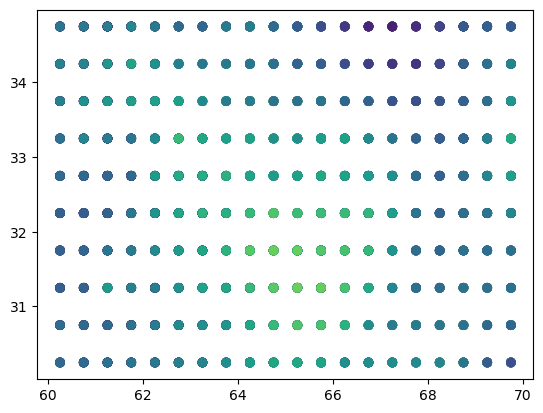

In [429]:
plt.scatter(np.mean(Xl[:, :, :, 1], axis=-1).reshape(-1), np.mean(Xl[:, :, :, 2], axis=-1).reshape(-1), c=np.var(Yl, axis=-2).reshape(-1))

In [427]:
kernel = gpflow.kernels.Matern32()

In [432]:
# list of num_split GPR models
submodels = bcm.get_latent_submodels(Xl, Zl, kernel=kernel, likelihood=likelihood)

AttributeError: module 'models.bcm' has no attribute 'get_latent_submodel'

In [ ]:
m_rbcm = guepard.baselines.Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.BCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [ ]:
m_rbcm.models[0].kernel.Kdiag(Xl[0])

AttributeError: 'SeparateIndependent' object has no attribute 'Kdiag'

In [ ]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbcm.training_loss,
                        m_rbcm.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_rbcm)

StagingError: in user code:

    File "/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 120, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 223, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "/Users/kenzatazi/Documents/CDT/Code/guepard_repo/guepard/baselines.py", line 166, in training_loss  *
        Yl = data[1]

    IndexError: list index out of range


In [ ]:
arr_in = np.mean(Xl, axis=-2).reshape(-1, 3)
arr_out = Yl.reshape(-1)

In [ ]:
arr_in

array([[ 1.  , 60.25, 30.25],
       [ 1.  , 60.25, 30.75],
       [ 1.  , 60.75, 30.25],
       ...,
       [12.  , 69.25, 34.75],
       [12.  , 69.75, 34.25],
       [12.  , 69.75, 34.75]])

In [ ]:
F = m_rbcm.predict_f_samples(arr_in, 3, full_cov=False, full_output_cov=False)
samples = F.numpy().squeeze()

In [ ]:
df = pd.DataFrame(samples.T, columns=["s1", "s2", "s3"])
df_melt = df.melt(var_name="sample", value_name="pr")

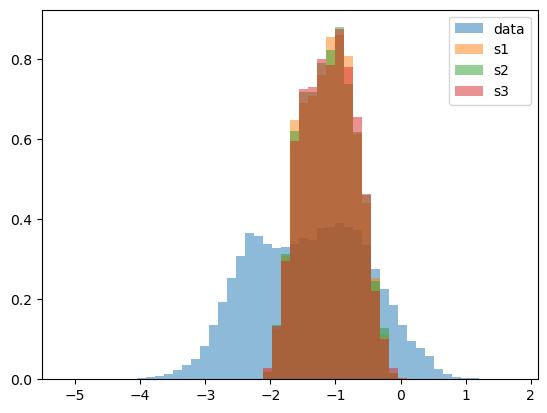

In [ ]:
# Check pdfs of data and sample
plt.figure()
n0, bins0, patches0 = plt.hist(arr_out, bins=50, alpha=0.5, label="data", density=True)
n1, bins1, patches1 = plt.hist(df['s1'].values, bins=bins0, alpha=0.5, label="s1", density=True)
n1, bins1, patches1 = plt.hist(df['s2'].values, bins=bins0, alpha=0.5, label="s2", density=True)
n1, bins1, patches1 = plt.hist(df['s3'].values, bins=bins0, alpha=0.5, label="s3",density=True)
plt.legend()

### Timeseries plot

In [ ]:
months = np.linspace(1, 12, 100).reshape(-1, 1)
loc_rep = np.tile([69.25, 31.25], (100,1))
ts_input = np.hstack([months, loc_rep])

In [ ]:
ypred, var = m_rbcm.predict_f(ts_input, full_cov=False, full_output_cov=False)#np.array(Xl).reshape(-1,3))
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [ ]:
df_temp['y_pred'] = df_temp['pred0'].values
df_temp['95th_u'] = df_temp['pred0'].values + 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['95th_l'] = df_temp['pred0'].values - 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)
df_temp[['time', 'lon', 'lat']] =ts_input

In [ ]:
df_temp

,pred0,var0,y_pred,95th_u,95th_l,CI,time,lon,lat
0,-1.369949,0.023997,-1.369949,-1.066329,-1.673569,0.607240,1.000000,69.25,31.25
1,-1.390019,0.022475,-1.390019,-1.096181,-1.683857,0.587676,1.111111,69.25,31.25
2,-1.398166,0.021296,-1.398166,-1.112138,-1.684195,0.572057,1.222222,69.25,31.25
3,-1.395822,0.020409,-1.395822,-1.115817,-1.675826,0.560009,1.333333,69.25,31.25
4,-1.384705,0.019758,-1.384705,-1.109204,-1.660206,0.551002,1.444444,69.25,31.25
...,...,...,...,...,...,...,...,...,...
95,-1.483221,0.020008,-1.483221,-1.205978,-1.760464,0.554487,11.555556,69.25,31.25
96,-1.474861,0.020941,-1.474861,-1.191229,-1.758492,0.567263,11.666667,69.25,31.25
97,-1.457402,0.022112,-1.457402,-1.165951,-1.748854,0.582902,11.777778,69.25,31.25
98,-1.429724,0.023564,-1.429724,-1.128850,-1.730598,0.601748,11.888889,69.25,31.25


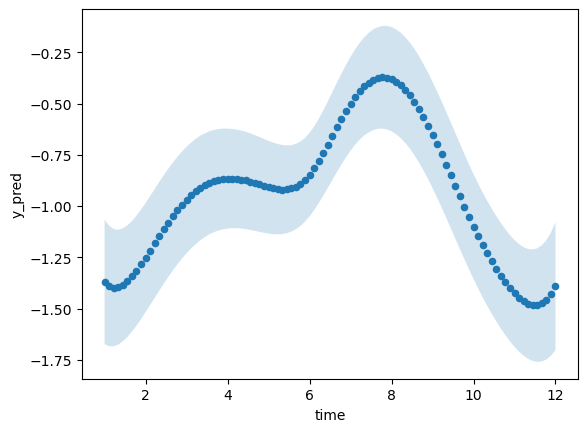

In [ ]:
df_temp.plot.scatter(x='time', y='y_pred')
plt.fill_between(df_temp['time'], df_temp['95th_l'], df_temp['95th_u'], alpha=0.2)

## Small subset of data

In [426]:
#arr_in[arr_in[:, 0] == 12., :].shape
check_input = arr_in[arr_in[:, 0] == 12., :]

NameError: name 'arr_in' is not defined

In [ ]:
ypred, var = m_rbcm.predict_f(check_input, full_cov=False, full_output_cov=False)#np.array(Xl).reshape(-1,3))
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [ ]:
df_temp['y_pred'] = df_temp['pred0'].values
df_temp['95th_u'] = df_temp['pred0'].values + 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['95th_l'] = df_temp['pred0'].values - 1.96 * np.sqrt(df_temp['var0'].values)
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)
df_temp[['time', 'lon', 'lat']] =check_input

In [ ]:
df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

# To Data Array
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)

<Axes: xlabel='lon', ylabel='lat'>

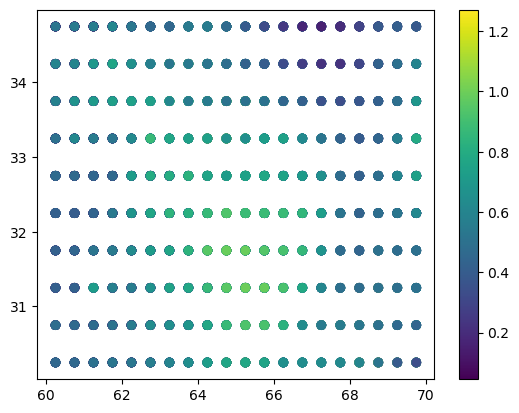

<Figure size 640x480 with 0 Axes>

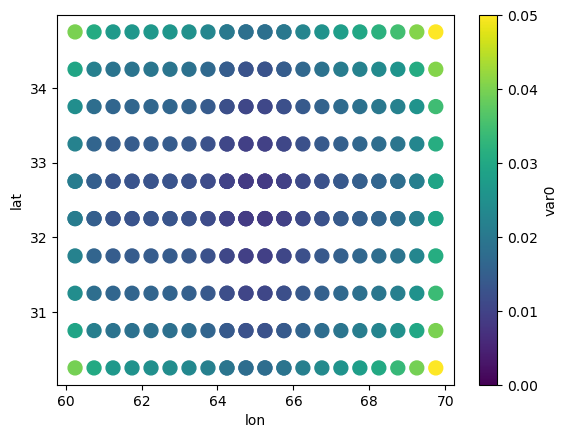

In [ ]:
plt.figure()
plt.scatter(np.mean(Xl[:, :, :, 1], axis=-1).reshape(-1), np.mean(Xl[:, :, :, 2], axis=-1).reshape(-1), c=np.var(Yl, axis=-2).reshape(-1))
plt.colorbar()

plt.figure()
df_temp.reset_index().plot.scatter(x='lon', y='lat', c='var0', vmin=0, vmax=0.05, cmap='viridis', s=100)

<Axes: xlabel='lon', ylabel='lat'>

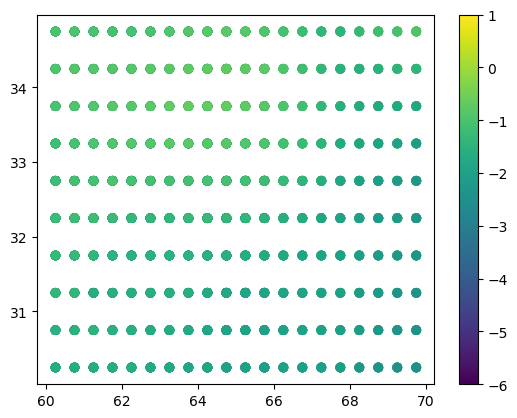

<Figure size 640x480 with 0 Axes>

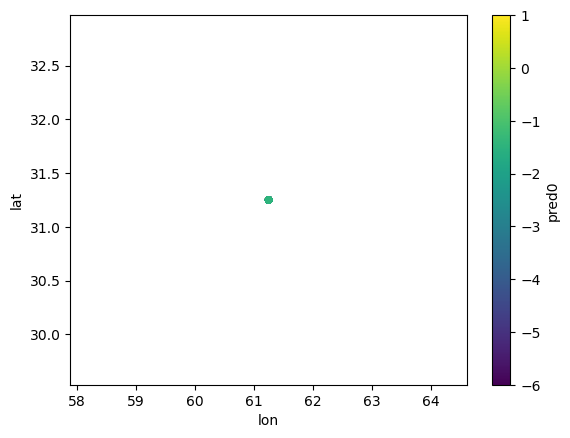

In [ ]:
plt.figure()
plt.scatter(np.mean(Xl[:, :, :, 1], axis=-1).reshape(-1), np.mean(Xl[:, :, :, 2], axis=-1).reshape(-1), c=np.mean(Yl, axis=-2).reshape(-1), vmin=-6, vmax=1)
plt.colorbar()

plt.figure()
df_temp.reset_index().plot.scatter(x='lon', y='lat', c='pred0', vmin=-6, vmax=1)

In [ ]:
#df_temp.drop_duplicates(inplace=True)
ds = df_temp.to_xarray()

In [ ]:
proj = ccrs.PlateCarree()
ds_avg_ypred = seasonal_means(ds.y_pred, 'y_pred')
ds_avg_CI = seasonal_means(ds.CI, 'CI')

# Map

ocean_50m = cf.NaturalEarthFeature("physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

g1 = ds_avg_ypred.plot(x="lon", y="lat", col="t", aspect=2, size=3, subplot_kws={"projection": proj}, cbar_kwargs={
    "label": "BCM posterior mean", 'pad': 0.03}, cmap='magma')

for ax in g1.axes.flat:
    ax.add_feature(ocean_50m)
    ax.set_extent([60, 100, 20, 40], crs=proj)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False

g2 = ds_avg_CI.plot(x="lon", y="lat", col="t",  aspect=2, cmap='magma', cbar_kwargs={
    "label": "BCM 95% CI [mm/day]", 'pad':0.03}, size=3, subplot_kws={"projection": proj})

for ax in g2.axes.flat:
    ax.add_feature(ocean_50m)
    ax.set_extent([60, 100, 20, 40], crs=proj)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False

TypeError: No numeric data to plot.

In [ ]:
np.var(Yl, axis=-2).squeeze().shape

(25, 96)